## Reverse Engineering the Mechanism of WeChat Red Envelope

In [25]:
from read_csv import *
import numpy as np
import matplotlib.pyplot as plt

# 1.Observation

First, we design three schemes: \
(1). 5 people 20 dollars 100 groups of experiments\
(2). 10 people 5 yuan 10 groups of experiments\
(3). 20 people, 5 pieces, 12 groups of experiments\
Among them, groups of 10 and 20 people are used as verification sets.\
As the main means to find the model, the group of 5 people has a large amount of data. Therefore, in order to avoid network delay, mobile phone model and other influencing factors as much as possible, we adopted different orders of grabbing red packets, and 20 groups were done in each order.

In [26]:
data05 = read_csv05('database/data05.csv')
data10 = read_csv10('database/data10.csv')
data20 = read_csv20('database/data20.csv')
print(data05.shape)
print(data10.shape)
print(data20.shape)

mean05 = np.mean(data05, axis=1)
mean10 = np.mean(data10, axis=1)
mean20 = np.mean(data20, axis=1)

data05_all = np.concatenate((data05[0], data05[1], data05[2], data05[3], data05[4]))


(5, 100)
(10, 10)
(20, 12)


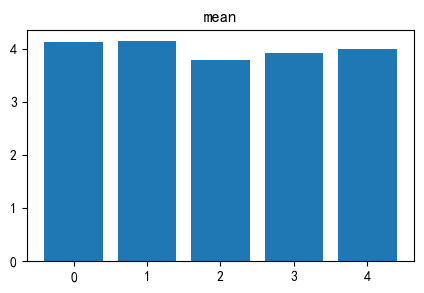

In [27]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (5,3)
plt.title("mean")
x=range(5)
plt.bar(x,mean05)
plt.show()

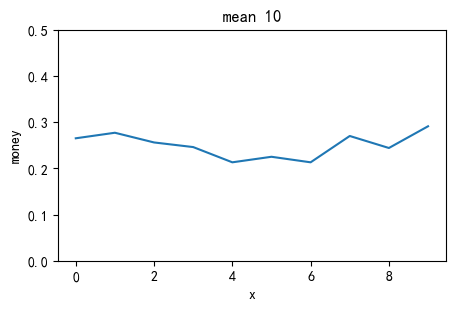

In [28]:
x = range(10)
plt.plot(x, mean10)
plt.title("mean 10")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)
plt.show()

Then, we made a scatter plot based on the data of the group of five people, and found that the amount of money stolen by the latter was more dispersed.

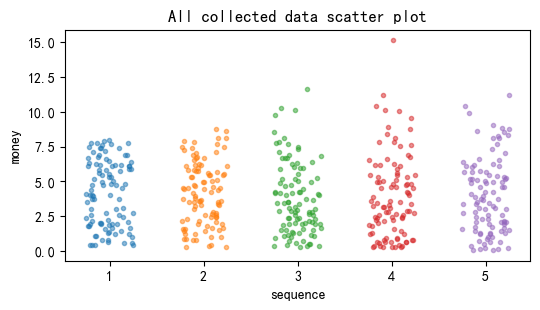

In [29]:
plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
plt.title("All collected data scatter plot")
plt.show()

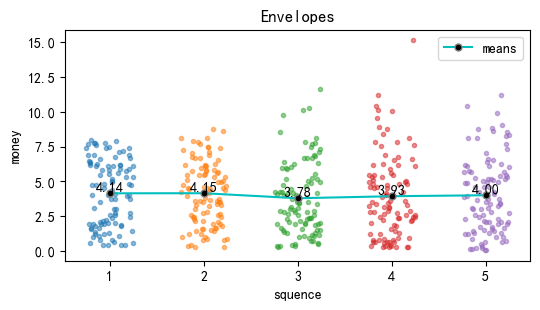

variance for each sqeuence:
[5.50708331 5.02952064 6.52382499 8.67529764 7.18975596]
standard deviation for each sqeuence:
[2.34671756 2.24265928 2.55417795 2.94538582 2.68137203]


In [30]:
plt.figure(figsize=(6,3))
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
x_label = range(1, 6)
plt.plot(x_label,mean05,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
plt.xlabel("squence")
plt.ylabel("money")
plt.legend()
plt.title("Envelopes")
for i, j in zip(x_label, mean05):
    plt.text(i, j, '%.2f' % j, ha='center', va='bottom', fontsize=10)
plt.show()
print("variance for each sqeuence:")
print(np.var(data05, axis=1))
print("standard deviation for each sqeuence:")
print(np.std(data05, axis=1))

Intuitively, the person who grabs it later is more likely to grab the big red envelope, but the person who grabs it first steals more on average. Let's start with the first person to grab the red envelope and try to figure out how it's distributed.\
By comparing our data with the four distributions, we find that the best fit is with the uniform distribution by calculating the residual sum of squares between the real data and the four distributions.

413.86999999999995


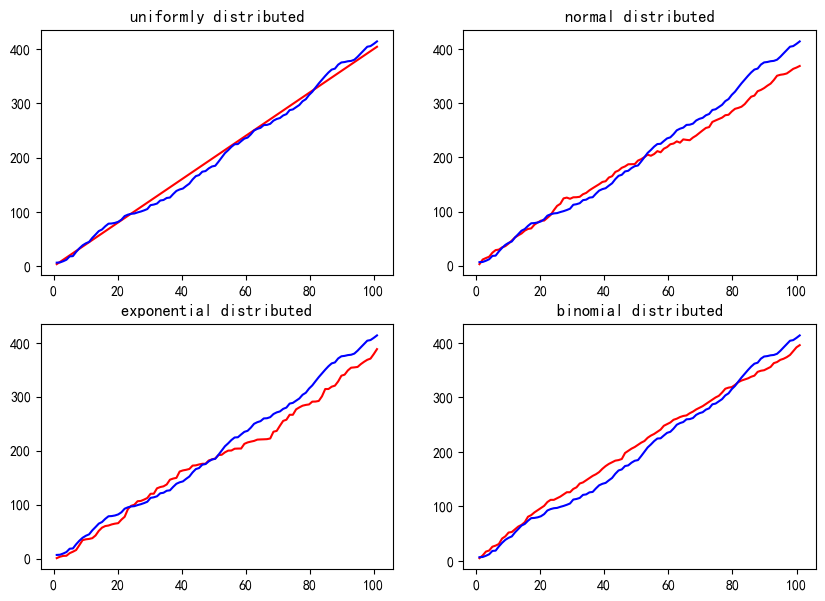

In [31]:
from find_distribution import *


data05_cdf0 = compute_cdf(data05[0])
print(data05_cdf0[99])


x_unif = np.linspace(1, 101, 100)
y_unif = x_unif * 4
# 2.3452 is obtained from sqrt of data05[0] variance
y_norm = np.random.normal(4, 2.3452, 100)
y_norm_cdf = compute_cdf(y_norm)
y_exp = np.random.exponential(4, 100)
y_exp_cdf = compute_cdf(y_exp)
y_binom = np.random.binomial(100, 0.04, 100)
y_binom_cdf = compute_cdf(y_binom)
plt.figure(figsize=(10, 7))
# uniformly distributed
plt.subplot(221)
plt.plot(x_unif, y_unif, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("uniformly distributed")
# normal distributed
plt.subplot(222)
plt.plot(x_unif, y_norm_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("normal distributed")
# exponential distributed
plt.subplot(223)
plt.plot(x_unif, y_exp_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("exponential distributed")
# binomial distributed
plt.subplot(224)
plt.plot(x_unif, y_binom_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("binomial distributed")
plt.show()

In [32]:
print("Loss of uniform distribution:", compute_loss(data05[0], np.zeros(100) + 4))
print("Loss of normal distribution:", compute_loss(data05[0], y_norm))
print("Loss of exponential distribution:", compute_loss(data05[0], y_exp))
print("Loss of binomial distribution:", compute_loss(data05[0], y_binom))

Loss of uniform distribution: 552.6321
Loss of normal distribution: 1276.8838178887847
Loss of exponential distribution: 1548.9569147989346
Loss of binomial distribution: 896.4521


Similarly, KL divergence can be used to compare our approximate distributions. It is found that the information lost by uniform distribution is smaller than that lost by the other three distributions.

In [33]:
print("KL divergence of uniform distribution:", KL_divergence(data05[0], np.zeros(100) + 4))
print("KL divergence of normal distribution:", KL_divergence(data05[0], y_norm))
print("KL divergence of exponential distribution:", KL_divergence(data05[0], y_exp))
print("KL divergence of binomial distribution:", KL_divergence(data05[0], y_binom))

KL divergence of uniform distribution: 0.18228341699566947
KL divergence of normal distribution: inf
KL divergence of exponential distribution: 0.685069770514718
KL divergence of binomial distribution: inf


## 2.Modeling.

Based on our data, we make a guess that the maximum amount of red packets each person can grab is twice the average of the remaining amount, and then try to prove it. 
Proof upper limit is 2 times the remaining average:\
Since the data set conforms to a uniform distribution, the prior distribution chooses a conjugate Pareto distribution.
$$p(a) \sim P(b,K) = 
\begin{cases}
    \frac{Kb^K}{a^{K+1}} & \text{if } a \geq b\\
    0                    & otherwise
\end{cases}
$$

where b is the smallest possible value, a is any number greater than b, and K is a positive parameter.
This is an important property of the Pareto distribution, namely that its probability density function starts at a = b and decreases when a > b. This density distribution function says that a must be greater than some constant b, but not too large, and K is used to control how much is too large.In a Pareto distribution, the value of the parameter K (the scaling parameter) determines the thickness of the "tail" of the distribution, that is, the frequency with which observations that are larger than the mean value 1 occur. The smaller the value of K, the thicker the tail, that is, the more likely it is that large observations will occur.If $K\to 0$ and $b\to 0$,then there is no information.\
The mean of this distribution is
$$E(a) = \frac{Kb}{K-1}$$
Given a Pareto prior, the joint distribution of and data set is
$$p(D,a) = \frac{Kb^K}{a^{N+K+1}},a \geq max(D)$$
where D represents the data set and N represents the size of the data set.\
\
Let m be the maximum value in D, then the evidence is
$$p(D) = \int_m^{\infty}\frac{Kb^K}{a^{N+K+1}}da =
\begin{cases}
    \frac{K}{(N+K)b^N}, & \text{if } m \leq b\\
    \frac{Kb^K}{(N+K)m^{N+k}}, & \text{if } m > b\\
\end{cases}
$$
We can find the PDF of m
$$Pr(max \leq m|a) = Pr(\text{all N samples} \leq m|a) = (\frac{m}{a})^N$$
$$p(m|a) = \frac{d}{dm}Pr(max \leq m|a) = \frac{N}{a}(\frac{m}{a})^{N-1}$$
$$E(m) = \int_0^aN(\frac{m}{a})^Ndm = \frac{Na}{N+1}$$
So the unbiased estimate of a is $\frac{(N+1)m}{N}$\
\
So the posterior mean can be written as $\frac{Nm}{N-1} = \frac{150}{149}\times19.88 = 20.01$

Moreover, we compare the maximum value of our data with the maximum value calculated by the formula, and find that the two are close. 

In [34]:
print(np.max(data05[0]))

7.96


In [35]:
print(101*7.96/100)

8.0396


To test the conjecture more accurately, we used the K-S test and tested the data for both the group of 10 and the group of 20. 

In [36]:
# generate 500 random numbers that are uniformly distributed
unif_data = np.random.uniform(0, 8, 2000)
print(ks_compare(unif_data, data05[0]))

True


The results show that the accuracy reaches 100% with a large amount of data from the group of five, but for the smaller data sets of the group of 10 and the group of 20, the accuracy decreases due to errors and other reasons, but it can still be maintained between 75% and 90%, which proves that our conjecture is correct.

In [37]:
from envelope import *

# the function of generate_envelopes uses algorithm of 0.01 ~ 2*mean
# use it to validate the samples' correctness
envelopes_validation05 = generate_envelopes(20, 5, 1000)
envelopes_validation10 = generate_envelopes(2.5, 10, 1000)
envelopes_validation20 = generate_envelopes(5, 20, 1000)
accuracy05 = 0
accuracy10 = 0
accuracy20 = 0
for i in range(5):
    accuracy05 += ks_compare(envelopes_validation05[i], data05[i])
for i in range(10):
    accuracy10 += ks_compare(envelopes_validation10[i], data10[i])
for i in range(20):
    accuracy20 += ks_compare(envelopes_validation20[i], data20[i])
print("Accuracy when giving 5 people:", accuracy05 * 100 / 5, "%")
print("Accuracy when giving 10 people:", accuracy10 * 100 / 10, "%")
print("Accuracy when giving 20 people:", accuracy20 * 100 / 20, "%")

Accuracy when giving 5 people: 100.0 %
Accuracy when giving 10 people: 90.0 %
Accuracy when giving 20 people: 80.0 %


Due to shortage of money, we can hardly get large samples of envelopes, but the accuracy is still very high even though the data's shape is less than or equal to 10, and gets larger with the size improving, proving that the algorithm we've predicted is correct. The inaccuracy shows that small samples couldn't represent the truth value.

## 3.Reproduce & Justification.

Then we run a lot of simulations to find patterns. In the data simulation of the group of five, we found that the degree of dispersion was consistent with the distribution of our real data. In the data simulation of the group of 10, 20 to 50 people, the expectation was roughly the same, and they all showed that the farther the red envelope was snatched, the greater the degree of dispersion of the amount snatched.

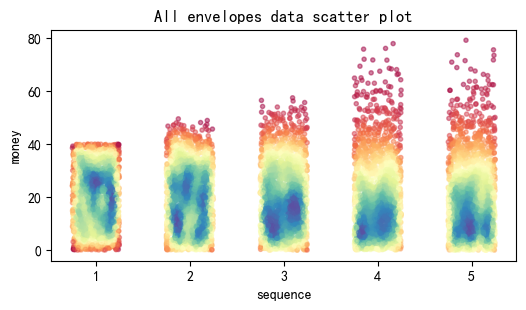

In [38]:
from scipy.stats import gaussian_kde

# envelopes = generate_envelopes(100, 5, 20000)
envelopes = generate_envelopes(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    # x = np.random.random(20000)
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All envelopes data scatter plot")
plt.show()

# about 16s

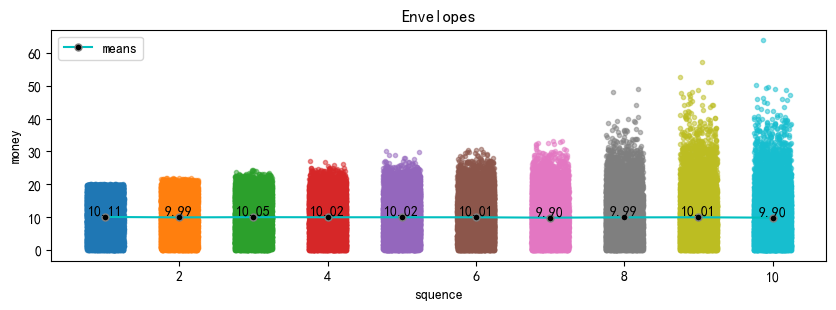

In [39]:
# envelopes_10 = generate_envelopes(100, 10, 1000000)
# draw_envelope_graph(envelopes_10, 10, 1000000)

envelopes_10 = generate_envelopes(100, 10, 10000)
draw_envelope_graph(envelopes_10, 10, 10000)

# about 1 min

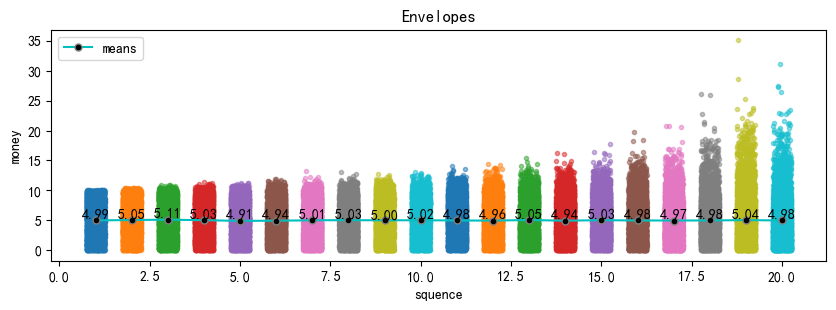

In [40]:
# envelopes_20 = generate_envelopes(100, 20, 500000)
# draw_envelope_graph(envelopes_20, 20, 500000)
envelopes_20 = generate_envelopes(100, 20, 5000)
draw_envelope_graph(envelopes_20, 20, 5000)

# about 1 min

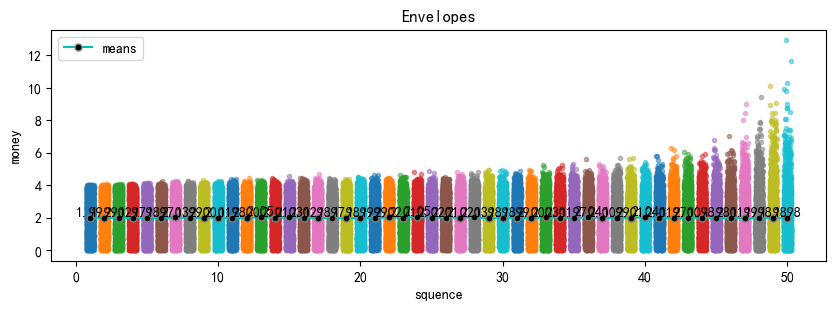

In [41]:
# envelopes_50 = generate_envelopes(100, 50, 200000)
# draw_envelope_graph(envelopes_50, 50, 200000)
envelopes_50 = generate_envelopes(100, 50, 2000)
draw_envelope_graph(envelopes_50, 50, 2000)

# about 1 min

Based on the study of the degree of dispersion, we analyze the variance of the amount of 10 people, 20 people and 50 people, and confirm the fact that the higher the variance is.

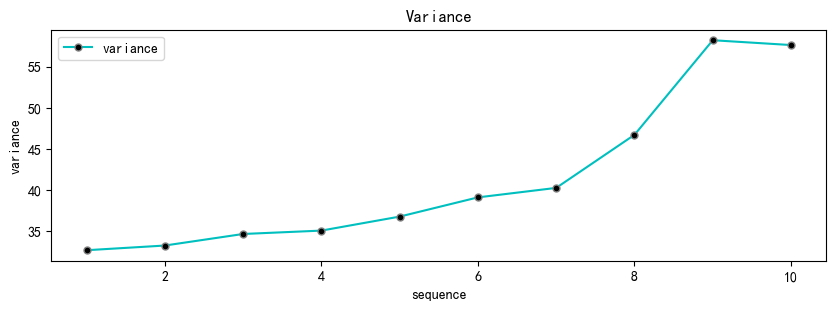

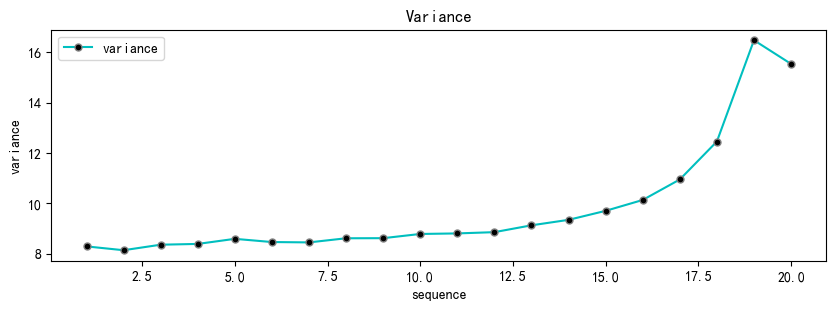

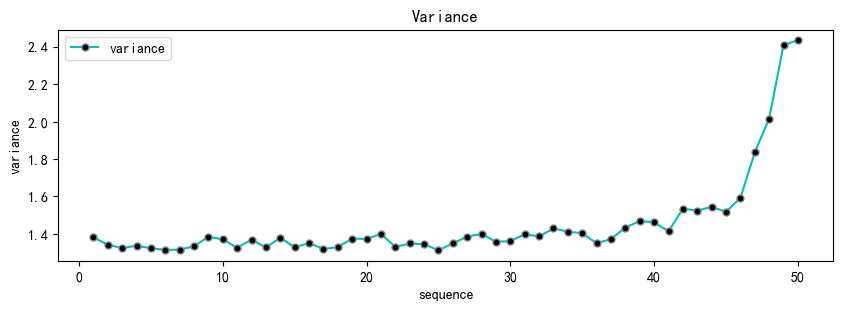

In [42]:
# plot variances
draw_variance(envelopes_10, 10)
draw_variance(envelopes_20, 20)
draw_variance(envelopes_50, 50)

## 4.From Analysis to Decision-Making Policy

We then want to find which position can get the biggest envelope

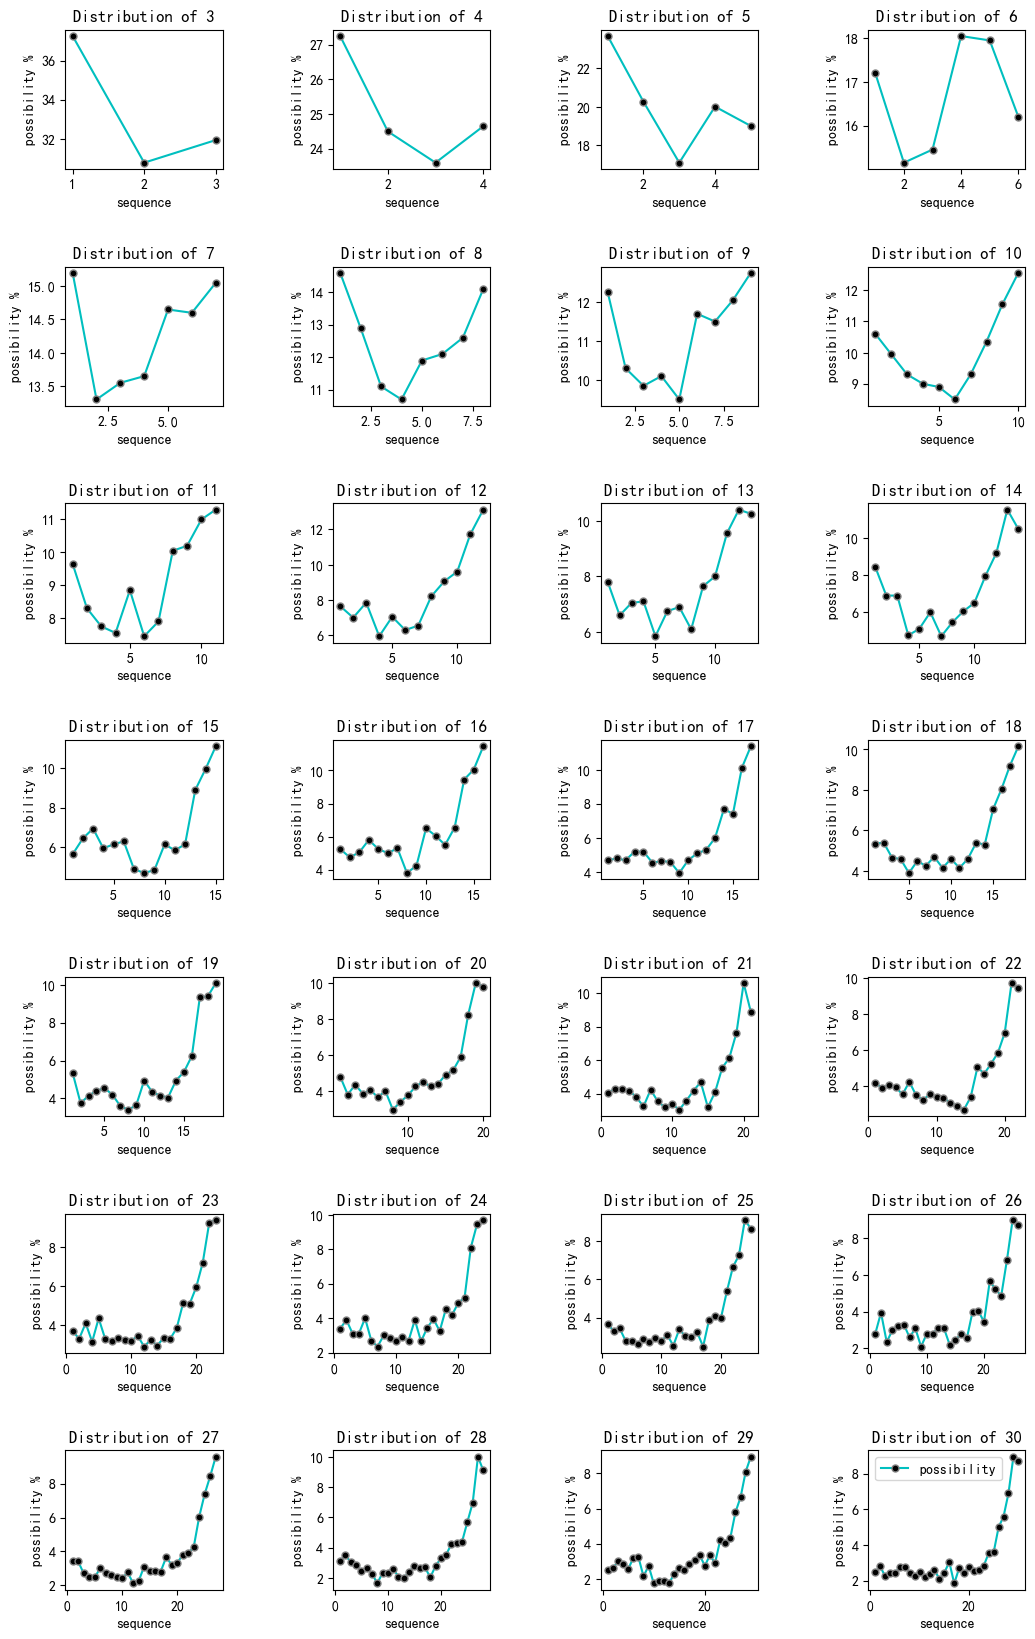

In [43]:
# find all distributions from n = 3 to n = 30
draw_distribution()

What about the price of it? Let's consider which position is more likely to get the smallest envelope!

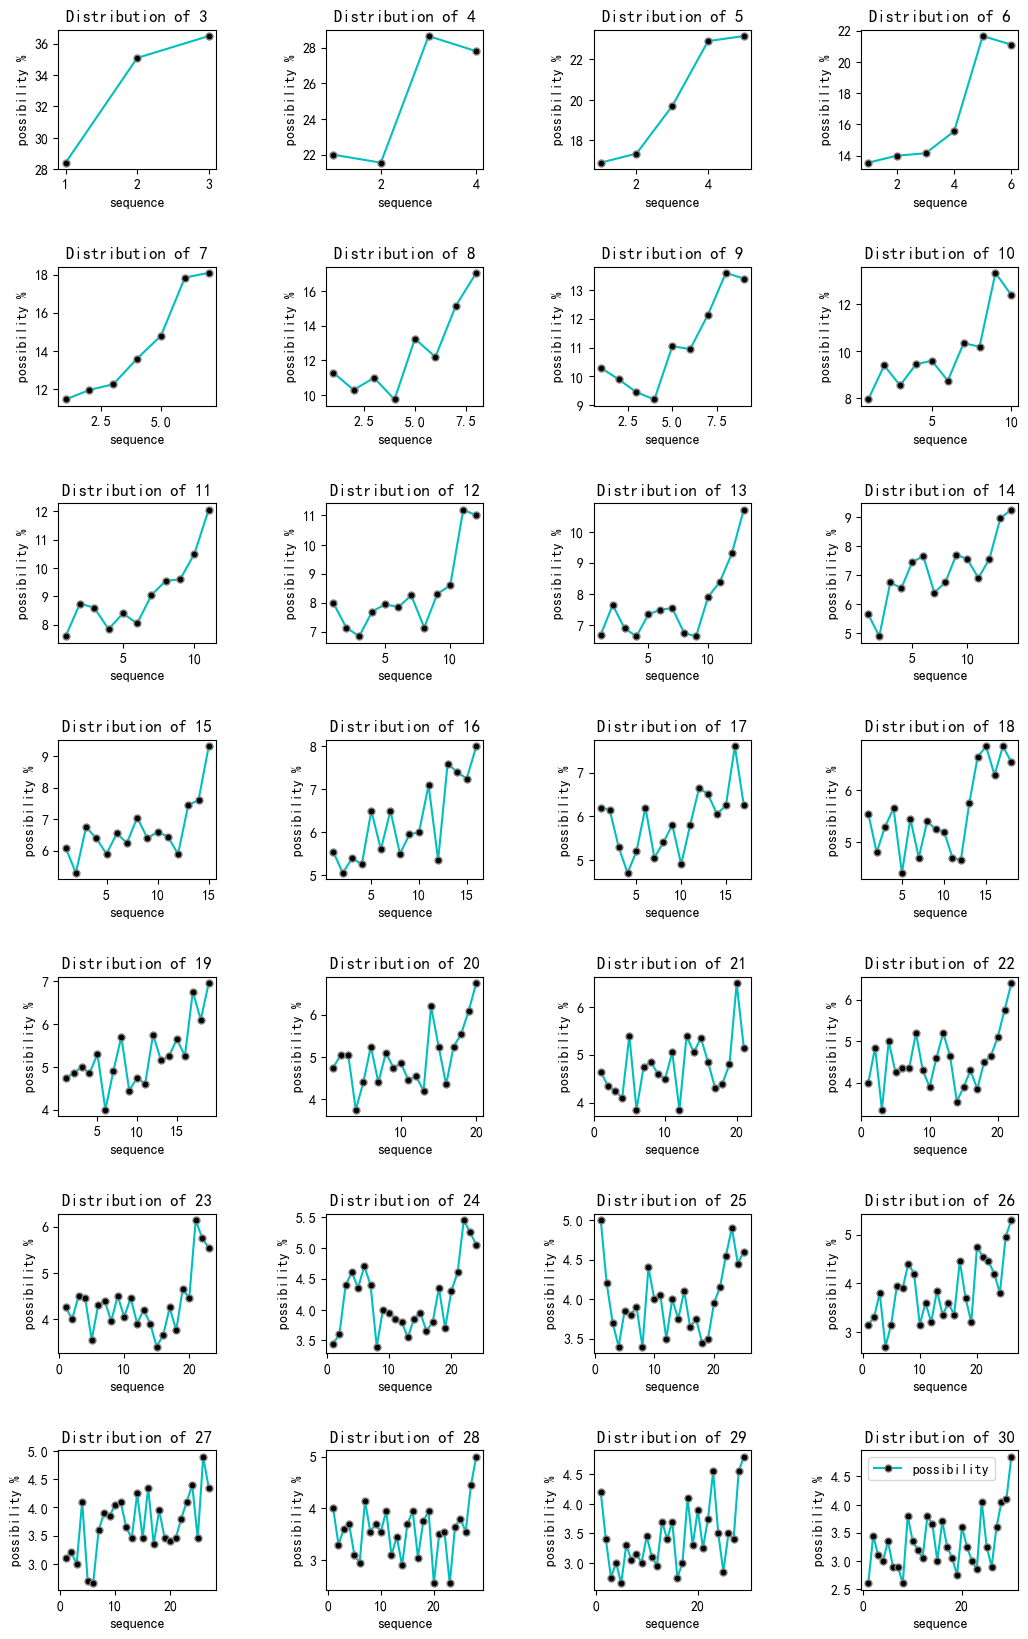

In [44]:
# find all distributions from n = 3 to n = 30
draw_distribution2()

We can also consider which position is more likely to get the medium envelope. 

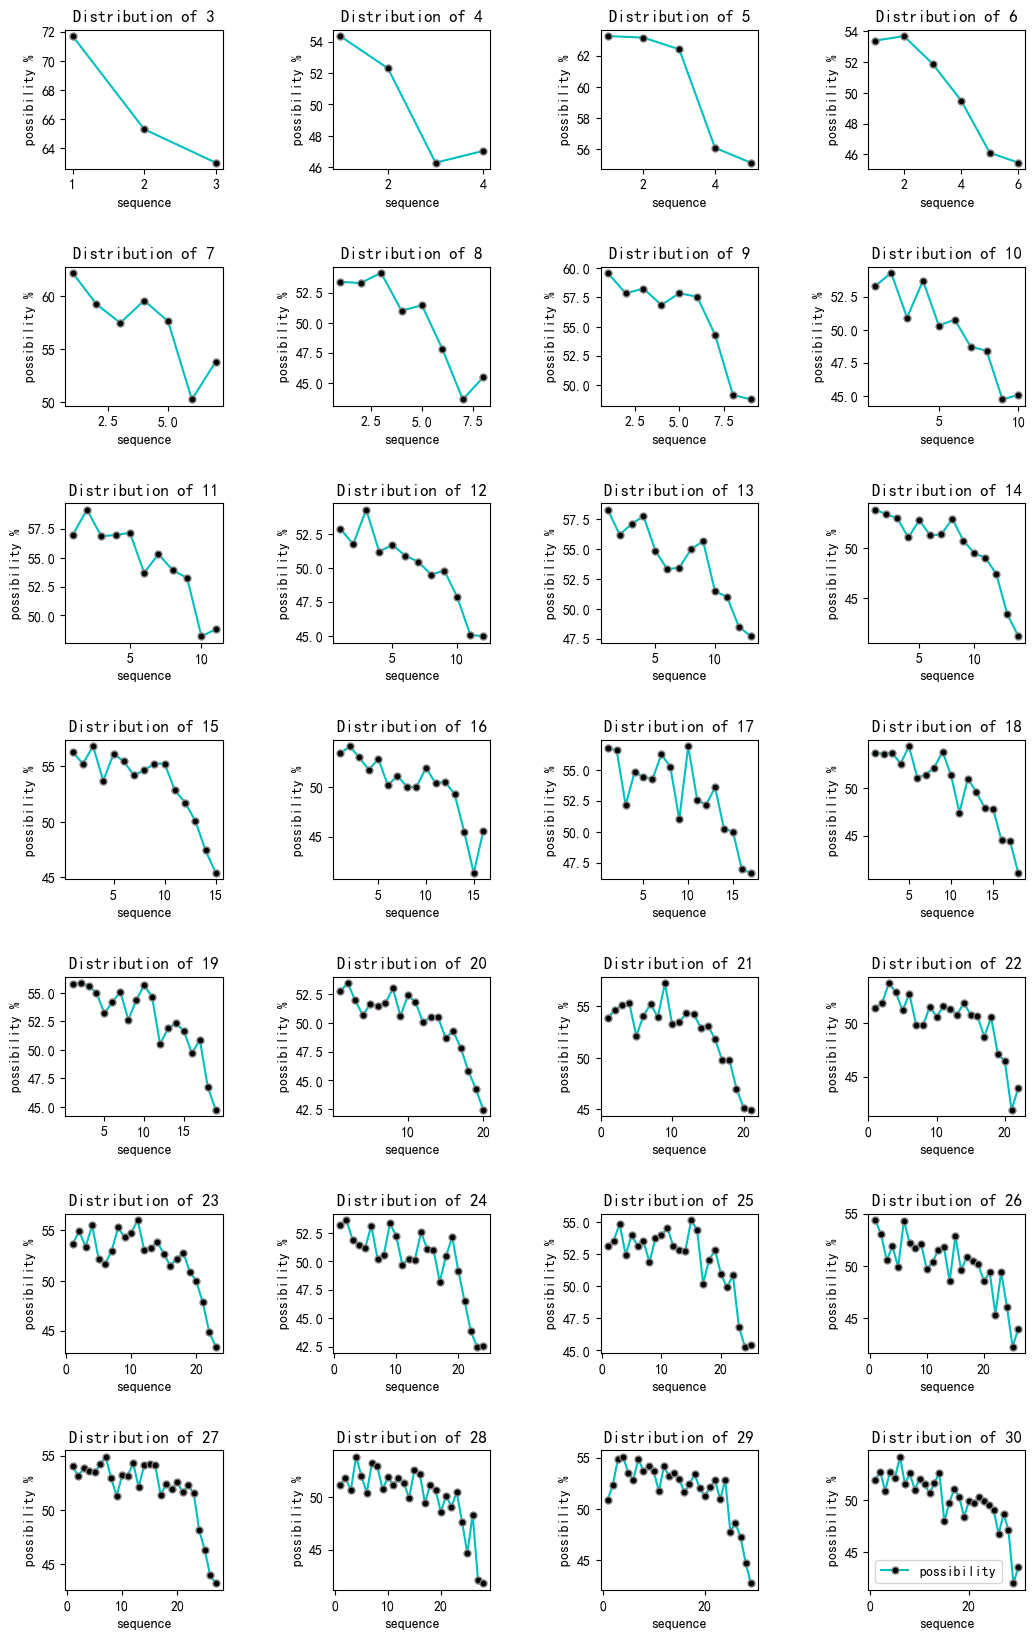

In [45]:
# find all distributions from n = 3 to n = 30
draw_distribution3()

According to the data of our statistical simulation above, we carried out the analysis of the strategy of grabbing red packets. \
1. First of all, the probability of grabbing the largest red envelope is analyzed: \
(1) In the range of 3-7 people, the first person to grab the most likely to grab the largest red envelope. \
(2) After 8 people, the last two people to grab the most likely to grab the largest red envelope. \
However, since the variance is larger and the probability of grabbing a small red envelope is also greater, we want to weigh the pros and cons and find a more secure scheme to grab the largest red envelope, so we conducted an analysis on how to grab the smallest red envelope. \
2. Analyze the probability of grabbing the smallest red envelope: \
(1) In the range of 3-7 people, the first person to grab the smallest probability of grabbing the red envelope, that is, the most likely to grab the largest red envelope. \
(2) The overall trend is that the person who grabs first is most likely to grab the smallest red envelope. \
(2) When the number of people is small, the trend of data growth fluctuates less. \
(3) When the number of people is large, the trend of data growth fluctuates greatly, and the probability of the last two people grabbing the smallest red envelope increases significantly. \
Combining the probability of grabbing the smallest red packet and the probability of grabbing the largest red packet, in the middle area, the probability of the two is not much different, so try to avoid grabbing the red packet in the middle position; In the last area, the probability of getting the maximum and minimum red packet increases, and the probability of difference between the two is larger, so we should grab the red packet at the end. \
To further verify our conclusion, we visualized the median amount of red packets captured. \
3. Analyze the probability that the amount of the red envelope is greater than or equal to the median: \
(1). In the range of 3-7 people, the probability of grabbing a red packet with the amount greater than or equal to the median is greater, indicating that the first person to grab a red packet is more guaranteed to grab a large red packet (not necessarily the largest). At this point, we conducted a triple verification of the conclusion that the earlier to grab a red packet in the range of 3-7 people, the better. \
(2) Greater than or equal to the median probability The graph tells us that the further we go, the greater the probability of grabbing below the median, especially the probability of the last few drops sharply. \
(3) If you want to grab the largest red envelope, the cost is that you need to accept a greater probability of getting a small red envelope and a greater probability of getting a red envelope below the median. \
Combined with the above three analyses, we can recommend the object of grabbing red envelopes
(1). In the scope of the number of people who grab red envelopes is small, all people should grab them as early as possible. \
(2). In the scope of the number of people grabbing red envelopes: \
①For those who want to grab a large red envelope (not necessarily the largest red envelope), the probability of grabbing the smallest red envelope is as small as possible, and those who do not want to take risks should grab it early. \
② For those who want to take more risks to grab the biggest red envelope, it is better to grab it last.

## 5.Further Explorations:

Next simulate red envelope solitaire:

interrupting end of game with 2797 times in 3 people
interrupting end of game with 4216 times in 4 people
interrupting end of game with 3920 times in 10 people
interrupting end of game with 4572 times in 11 people
interrupting end of game with 3001 times in 12 people
interrupting end of game with 2928 times in 13 people
interrupting end of game with 3130 times in 14 people
interrupting end of game with 2506 times in 15 people
interrupting end of game with 2303 times in 16 people
interrupting end of game with 2339 times in 17 people
interrupting end of game with 1967 times in 18 people
interrupting end of game with 2512 times in 19 people
interrupting end of game with 2028 times in 20 people
interrupting end of game with 1910 times in 21 people
interrupting end of game with 1840 times in 22 people
interrupting end of game with 2028 times in 23 people
interrupting end of game with 2037 times in 24 people
interrupting end of game with 1760 times in 25 people
interrupting end of game with 

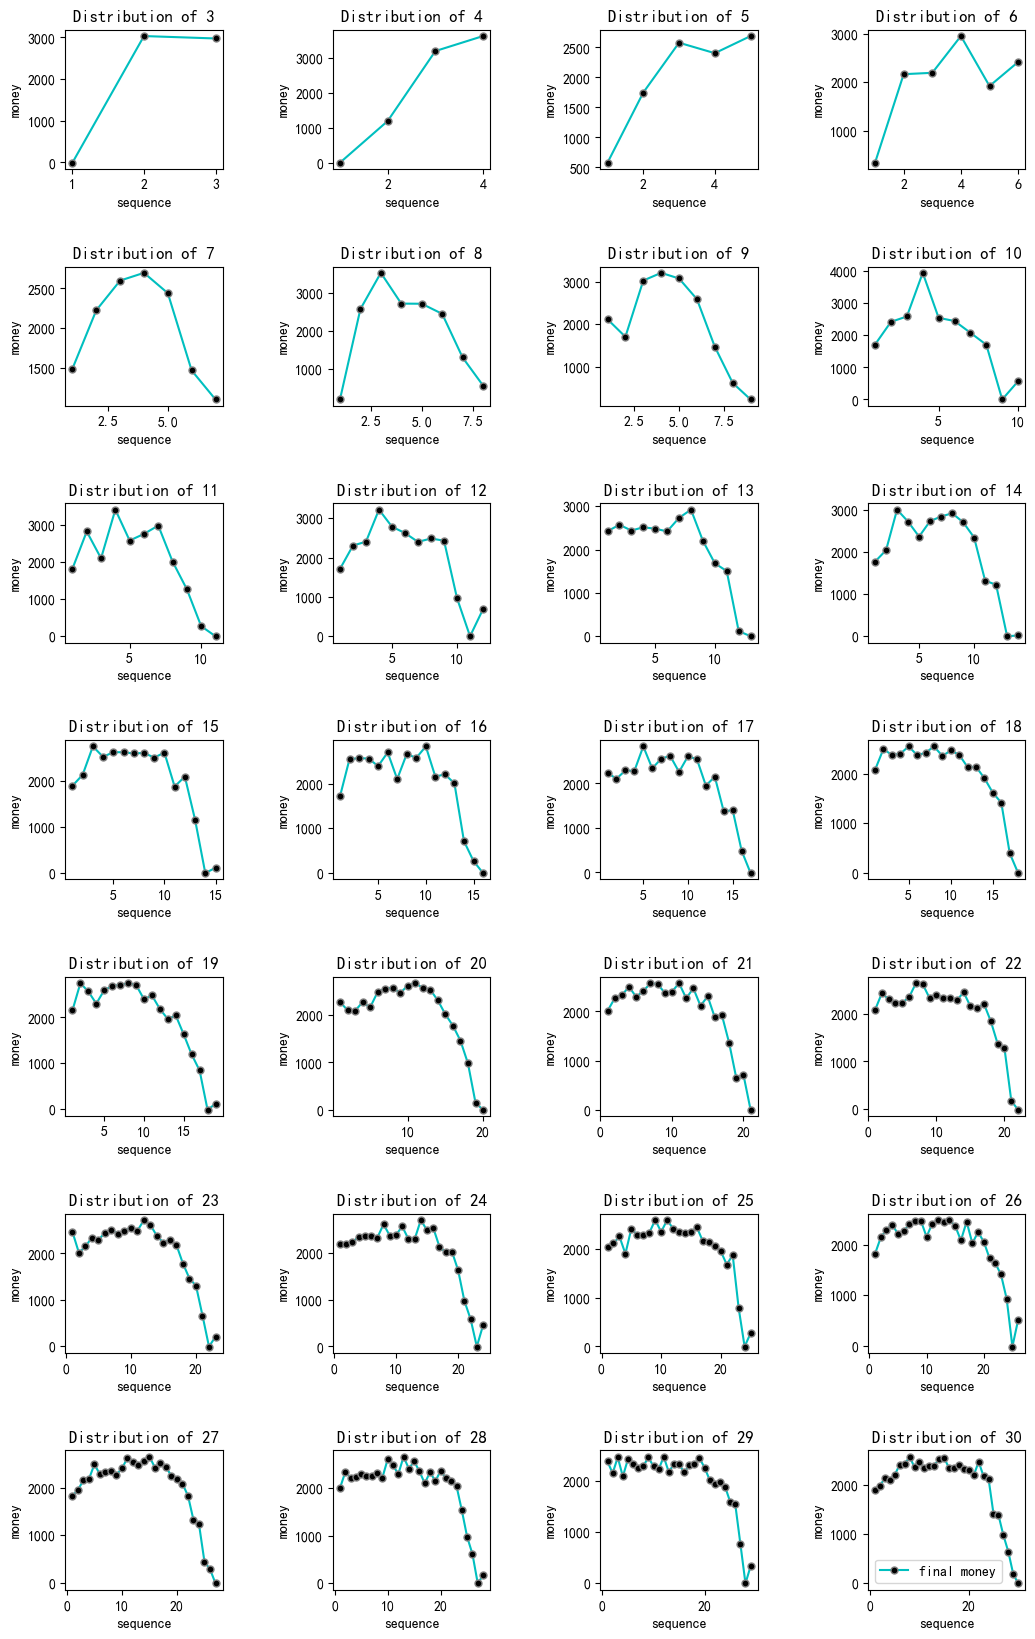

In [46]:
envelope_group_note()

User specific WRE mechanism: We can make the bias of each random money smaller, in order to improve the fairness for children

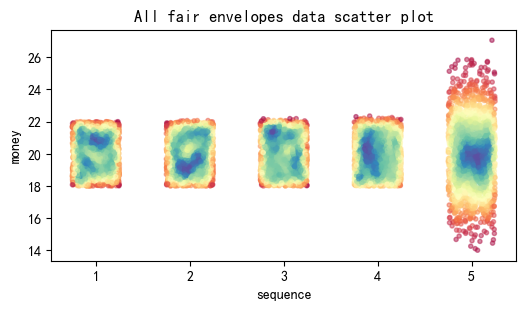

[20.00564  20.003565 20.026885 19.972545 19.991365]
[1.30456599 1.31865404 1.38469225 1.37063657 4.64056409]


In [47]:
fair_envelopes = generate_fair_envelopes(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,fair_envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, fair_envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All fair envelopes data scatter plot")
plt.show()
# print mean of envelope 0 to 4
print(np.mean(fair_envelopes, axis=1))
print(np.var(fair_envelopes, axis=1))

This method is to subtract the money generated by the original method and the average value, which effectively reduces the variance, but due to the accuracy problem, the variance of the last red envelope is still too large, so another idea is to set the amount of red envelope in advance to distribute

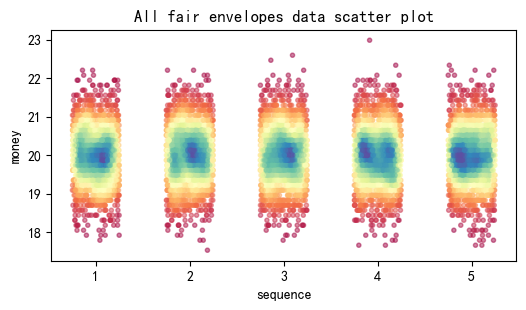

[19.999935 20.015405 19.996555 19.9935   19.994605]
[0.52899535 0.53643064 0.53609838 0.54437435 0.53226174]


In [48]:
fair_envelopes2 = generate_fair_envelopes2(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,fair_envelopes2[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, fair_envelopes2[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All fair envelopes data scatter plot")
plt.show()
# print mean of envelope 0 to 4
print(np.mean(fair_envelopes2, axis=1))
print(np.var(fair_envelopes2, axis=1))

This method is obviously more equitable in distribution.

### Successive Fairness Red Envelopes
Suppose there are 5 people giving envelopes to each other, in order to prevent one always get least and get sad about it, we can increase the probability of who get minimum money and decrease the probability of getting the max money of money attribute. All starts with 20% winning chance.

We can setup an "unlucky threshold" and an "overlucky threshold". Let $C$ be the total amounts of money, and $N$ be the number of people in this group. So I will set the unlucky threshold $T_L$ and overlucky threshold $T_H$ as follows: 
$$
T_L = \frac{1}{2}\cdot\frac{C}{N}
$$
$$
T_H = 2\cdot\frac{C}{N}
$$
Anyone whose received money is **less** than $T_L$ will be counted as **unlucky**, and his probability of winning the money will go up to 105% of the previous value. Anyone whose received money is **greater** than $T_H$ will be counted as **overlucky**, and his probability of winning the money will go down to $\frac{100}{105}$ of the previous value. Then their winning probability will be normalized to make sure the sum equals to 1. 

Here's a result with 20 samples. (Too much samples will make the graph unreadable)

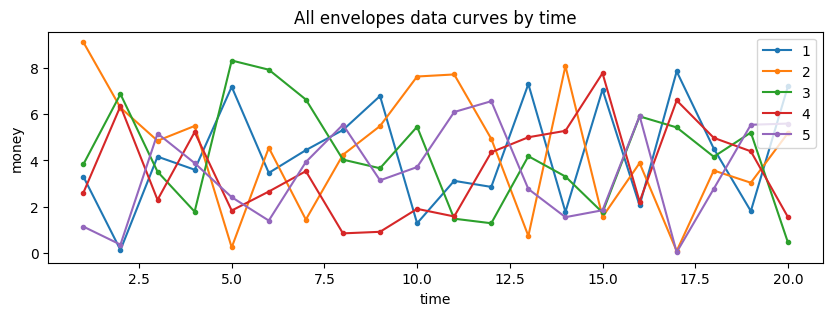

In [8]:
envelopes_fair = generate_fair_envelopes3(20, 5, 20)
draw_envelope_sequence(envelopes_fair, 5, 20)

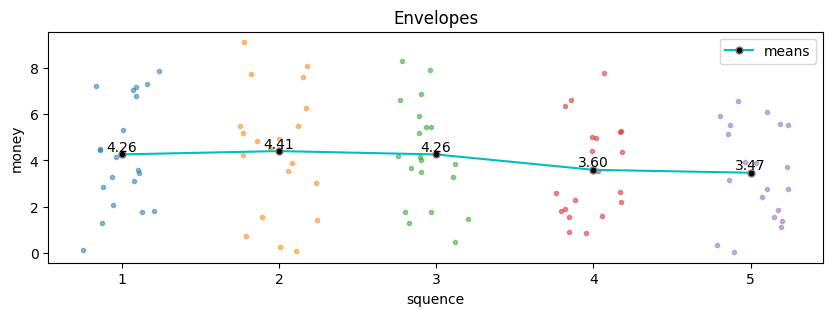

In [9]:
from envelope import draw_envelope_graph
draw_envelope_graph(envelopes_fair, 5, 20)

You can find out that for each curves (which representing a person), there is neither so much continuous low points and continuous high points. Their means are similar too. This can increase the fairness of the envelopes. 